# Solving the wave equation with PINN

Suppose we are to solve a one-dimensional wave equation 
$$
\frac{\partial^2 u}{\partial t^2}-a^2\frac{\partial^2 u}{\partial x^2} = 0
$$
where the initial condition is a gaussian wave packet moving in the positive direction of the x-axis
$$
u|_{t=0}=e^{-x^2}
$$
$$
\left.\frac{\partial u}{\partial t}\right|_{t=0}=2axe^{-x^2}
$$
Imagine that this wave packet propagates along a one-dimensional rope, with the end of the rope fixed at a point where it cannot be moved, then the boundary condition is
$$
u|_{x=x_{max}}=0
$$

In this problem, we know the initial conditions of this one-dimensional wave packet and the boundary conditions of the problem, and we know that the wave packet follows the wave equations to evolve in time and space, but we do not know the specific form of the wave packet to evolve in time and space (which is $u(t,x)$). However, by designing the loss function of PINN so that the wave in a given time and space satisfies the wave equation, the boundary conditions, and the initial conditions, we can find the form of the wave at given time and location within a certain accuracy.


## Setup PINN

Let
$$
F(t,x) = \frac{\partial^2 u}{\partial t^2}-a^2\frac{\partial^2 u}{\partial x^2}
$$
be the residual of wave equation. Given a neural network with $(t,x)$ as input and $u(t,x)$ as output, the training process will compute its loss under the following known conditions:
- Wave equation: $$F(t,x)\to 0$$
- Initial condition: $$I_1 = u(t=0, x) - e^{-x^2} \to 0$$ $$I_2 = u_t(t=0, x) - 2axe^{-x^2}\to 0$$
- Boundary condition: $$B = u(t,x=x_{max}) \to 0$$

If we design the loss function of the neural network as a combination of the above conditions
$$
loss = F(t,x) + I_1 + I_2 + B
$$
As training proceeds, the neural network will learn about this physical scene by reducing the loss function to be able to give u(t,x) at any (t,x).



Let's build the network. In this demo, we use `tensorflow` as the deeplearning framework. One could easily install tensorflow to a virtual environment by `conda`:
```shell
conda create -n tf-pinn tensorflow imageio matplotlib jupyter python=3.9
conda activate tf-pinn
```

The following packages should be able to imported.

In [1]:
import tensorflow as tf
import numpy as np
from time import time
import os
import imageio
import copy
import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

# set the following path to /path/to/your/ffmpeg
plt.rcParams['animation.ffmpeg_path'] = "./ffmpeg-2022-12-08-git-9ca139b2aa-essentials_build/bin/ffmpeg.exe"

# set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# set random seed
tf.random.set_seed(0)

We design the neural network as a simple fully connected network with a 2-dimensional input layer to receive $t$ and $x$ and a 1-dimensional output layer to output $u$. The number of layers in the intermediate layers and the number of nodes in each layer are specified by the `layers`.

In [2]:
class WaveModel(tf.keras.Sequential):
    def __init__(self, layers, lb, ub, a):
        super().__init__()
        # 2 dimensional input, t and x
        self.add(tf.keras.Input(2))
        # scaling layer
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0
        )
        self.add(scaling_layer)
        # hidden layers
        for n in layers:
            self.add(tf.keras.layers.Dense(
                n, 
                activation=tf.keras.activations.get('tanh'),
                kernel_initializer=tf.keras.initializers.GlorotNormal()
            ))
        # output layer
        self.add(tf.keras.layers.Dense(1))

        # additional parameters
        self.a = a

    def predict(self, X):
        return self.call(X)

    # residual of wave equation, which is F(t,x)
    def _func_r(self, u_tt, u_xx):
        return u_tt - self.a * u_xx
    
    # get residual of wave equation
    # calculate derivatives by tape.gradient
    # where the tape is tf.GradientTape, which is used to 
    # track the gradient of the variable
    def get_r(self, X):
        with tf.GradientTape(persistent=True) as tape:
            t, x = X[:, 0:1], X[:, 1:2]
            tape.watch(t)
            tape.watch(x)

            u = self.call(tf.stack([t[:, 0], x[:, 0]], axis=1))
            u_t = tape.gradient(u, t)
            u_x = tape.gradient(u, x)

        u_tt = tape.gradient(u_t, t)
        u_xx = tape.gradient(u_x, x)

        r = self._func_r(u_tt, u_xx)
        return r
    
    # the loss is the sum of three parts
    # w_u0, w_ut0, w_ub is the weight of each part
    # use tape.batch_jacobian to calculate the derivatives under initial/boundary conditions
    def compute_loss(self, X0, u0, ut0, Xb, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val):
        # equation loss
        r = self.get_r(X_train)
        l0 = tf.reduce_mean(tf.square(r))

        # boundary loss at u(x, t=0)
        u0_pred = self.call(X0)
        l1 = tf.reduce_mean(tf.square(u0_pred - u0))

        u0_pred_val = self.call(X0_val)
        l1_val = tf.reduce_mean(tf.square(u0_pred_val - u0_val))

        # boundary loss at u_t(x, t=0)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X0)
            tape.watch(X0_val)
            u0_pred = self.call(X0) 
            u0_pred_val = self.call(X0_val)
        ut0_pred = tape.batch_jacobian(u0_pred, X0)[:, :, 0]
        ut0_pred_val = tape.batch_jacobian(u0_pred_val, X0_val)[:, :, 0]
        l2 = tf.reduce_mean(tf.square(ut0_pred - ut0))
        l2_val = tf.reduce_mean(tf.square(ut0_pred_val - ut0_val))

        # boundary loss at border like u_x(t, x=xmax)
        # loss set as ub_x = 0 
        ubx_pred = self.call(Xb)
        ubx_pred_val = self.call(Xb_val)
        l3 = tf.reduce_mean(tf.square(ubx_pred))
        l3_val = tf.reduce_mean(tf.square(ubx_pred_val))

        # loss summary
        loss = l0 + w_u0 * l1 + w_ut0 * l2 + w_ub * l3
        loss_val = w_u0 * l1_val + w_ut0 * l2_val + w_ub * l3_val
        return loss, loss_val
    
    # calculate gradients of the network
    def get_grad(self, X0, u0, ut0, Xb, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.trainable_variables)
            loss, loss_val = self.compute_loss(X0, u0, ut0, Xb, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val)
        grad = tape.gradient(loss, self.trainable_variables)
        return grad, loss, loss_val
    
    # fit the data by training
    def fit(self, X0, u0, ut0, Xb, ub, X_train, w_u0, w_ut0, w_ub, N_iter=1000, optimizer=None):
        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        # split data: 80% for train, 20% for validation
        X0_train, X0_val = tf.split(X0, [int(0.8*X0.shape[0]), int(0.2*X0.shape[0])], axis=0)
        u0_train, u0_val = tf.split(u0, [int(0.8*u0.shape[0]), int(0.2*u0.shape[0])], axis=0)
        ut0_train, ut0_val = tf.split(ut0, [int(0.8*ut0.shape[0]), int(0.2*ut0.shape[0])], axis=0)
        Xb_train, Xb_val = tf.split(Xb, [int(0.8*Xb.shape[0]), int(0.2*Xb.shape[0])], axis=0)
        # ub = 0, ignored here

        @tf.function
        def train_step():
            grad_theta, loss, loss_val = self.get_grad(X0_train, u0_train, ut0_train, Xb_train, X_train, w_u0, w_ut0, w_ub, X0_val, u0_val, ut0_val, Xb_val)
            optimizer.apply_gradients(zip(grad_theta, self.trainable_variables))
            return loss, loss_val

        hist_train = []
        hist_val = []
        t0 = time()

        for i in range(N_iter+1):
            loss_train, loss_val = train_step()
            # loss_b1, loss_b2 = self.get_bound_r(X0_val, u0_val, ut0_val)
            hist_train.append(loss_train.numpy())
            # hist_val.append(w_u0 * loss_b1.numpy() + w_ut0 * loss_b2.numpy())
            hist_val.append(loss_val.numpy())

            if i%10 == 0:
                print('\r iteration: {:05d}, train loss: {:10.8e} test bound loss: {:10.8e}'.format(i, loss_train, loss_val), end='')
            if i%1000 == 0:
                print('')

        print('\n')
        print('time: {:.2f} sec'.format(time() - t0))
        print('final train loss: {:10.8e}'.format(loss_train))

        return hist_train, hist_val


The loss is defined in `compute_loss` function. `l0`, `l1`, `l2`, `l3` each stands for loss on wave equation, $u(t=0,x)$, $u_t(t=0,x)$ and $u(t,x=0)$. `_val` stands for validation to check the deviation on the initial/boundary conditions.

## Generate data for training

Let $x_{min}=-5$, $x_{max}=5$, $a=1$, and we try to calculate the evolution from $t=0$ to $t=5$

In [3]:
a = 1
x_min, x_max = -5, 5
t_min, t_max = 0, 10

Firstly, we generate the data for training on the wave equation part. During the training process, the residual of wave equation would be calculated at $x\in [x_{min}, x_{max}]$ and $t\in [t_{min}, t_{max}]$. For simplicity, we randomly and uniformly sample over this range.

In [4]:
N_train = 1000  # number of points along each dimension
t_train = tf.random.uniform((N_train, 1), t_min, t_max, dtype=DTYPE)
x_train = tf.random.uniform((N_train, 1), x_min, x_max, dtype=DTYPE)
X_train = tf.concat([t_train, x_train], axis=1)

Then, we generate the data for training on the initial condition part. Recall the initial condition
$$
u|_{t=0}=e^{-x^2}
$$
$$
\left.\frac{\partial u}{\partial t}\right|_{t=0}=2axe^{-x^2}
$$

In [5]:
N_init = 1000
x_init = tf.cast(tf.linspace([x_min], [x_max], N_init), DTYPE)  # '[]' here to create (N, 1) shape
t_init = tf.ones_like(x_init, dtype=DTYPE) * t_min   # t_min=0 here
X_init = tf.concat([t_init, x_init], axis=1)

# the u(t=0, x)
u_init = tf.exp(-tf.square(x_init))

# the u_t(t=0, x)
ut_init = 2*a*x_init*u_init

... and the boundary condition
$$
u|_{x=x_{max}}=0
$$

In [6]:
N_bound = 1000
t_bound = tf.cast(tf.linspace([t_min], [t_max], N_bound), DTYPE)
x_bound = tf.ones_like(t_bound, dtype=DTYPE) * x_max
X_bound = tf.concat([t_bound, x_bound], axis=1)

# the u(t, x=x_max)
u_bound = tf.zeros_like(t_bound, dtype=DTYPE)

For simplicity, we set the weight of loss on each condition to $1$.

In [7]:
w_u_init, w_ut_init, w_u_bound = 1, 1, 1 

Let's check the data we generated

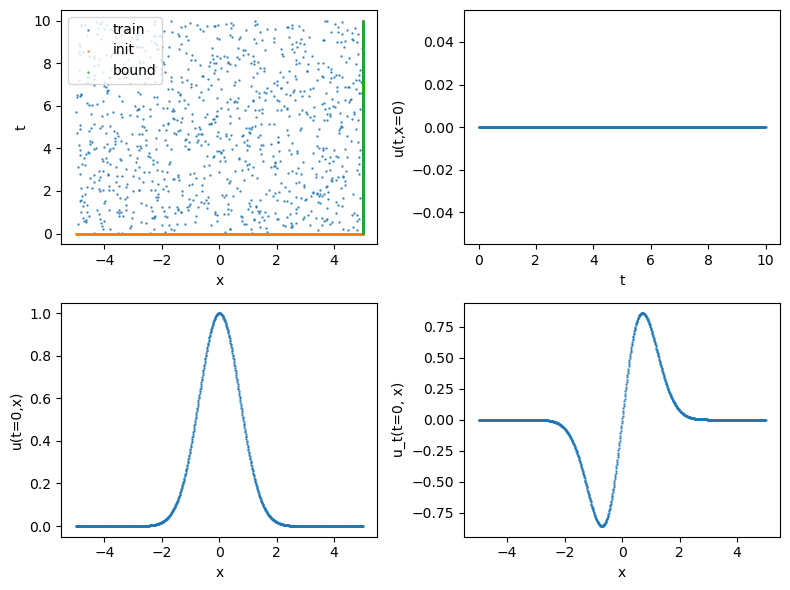

In [8]:
fig = plt.figure(figsize=(8, 6))

ax11 = fig.add_subplot(221)
ax11.scatter(x_train, t_train, s=2, marker='.', alpha=0.8, label='train')
ax11.scatter(x_init, t_init, s=2, marker='.', alpha=0.8, label='init')
ax11.scatter(x_bound, t_bound, s=2, marker='.', alpha=0.8, label='bound')
ax11.set_xlabel('x')
ax11.set_ylabel('t')
ax11.legend(loc='upper left')

ax12 = fig.add_subplot(222)
ax12.scatter(t_bound, u_bound, s=2, marker='.', alpha=0.8)
ax12.set_xlabel('t')
ax12.set_ylabel('u(t,x=0)')

ax21 = fig.add_subplot(223)
ax21.scatter(x_init, u_init, s=2, marker='.', alpha=0.8)
ax21.set_xlabel('x')
ax21.set_ylabel('u(t=0,x)')

ax22 = fig.add_subplot(224)
ax22.scatter(x_init, ut_init, s=2, marker='.', alpha=0.8)
ax22.set_xlabel('x')
ax22.set_ylabel('u_t(t=0, x)')

fig.tight_layout()
plt.show()
plt.close(fig=fig)

## Train the PINN

Firstly we initialize the PINN. We set the hidden layers to be a 4x10 network. Notice that the scaling layer needs the lower bounduary and the upper boundary info to scale the data from $[x_{min}, x_{max}]$ and $[t_{min}, t_{max}]$ to $[0, 1]$. 

In [9]:
layers = [10, 10, 10, 10]   # hidden layers
lb = tf.constant([t_min, x_min], dtype=DTYPE)   # lower boundary
ub = tf.constant([t_max, x_max], dtype=DTYPE)   # upper boundary
model = WaveModel(layers, lb, ub, a)

We use the Adam optimizer to solve this problem

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

Then we can start training the PINN. Let's start with $10000$ iterations.

In [11]:
N_iter = 10000
hist_train, hist_val = model.fit(
    X_init, u_init, ut_init, 
    X_bound, u_bound, 
    X_train, 
    w_u_init, w_ut_init, w_u_bound, 
    N_iter=N_iter, 
    optimizer=optimizer
)

 iteration: 00000, train loss: 4.65116560e-01 test bound loss: 7.19426647e-02
 iteration: 01000, train loss: 7.92091805e-03 test bound loss: 9.56828531e-04
 iteration: 02000, train loss: 7.42233032e-03 test bound loss: 3.84708896e-04
 iteration: 03000, train loss: 3.24509363e-03 test bound loss: 4.03576589e-04
 iteration: 04000, train loss: 2.48421362e-04 test bound loss: 8.94171302e-04
 iteration: 05000, train loss: 1.18971409e-04 test bound loss: 2.62497721e-04
 iteration: 06000, train loss: 7.83035503e-05 test bound loss: 7.96917593e-05
 iteration: 07000, train loss: 6.18978011e-05 test bound loss: 3.65100132e-05
 iteration: 08000, train loss: 5.20133690e-05 test bound loss: 2.76009123e-05
 iteration: 09000, train loss: 5.40691617e-05 test bound loss: 4.32080960e-05
 iteration: 10000, train loss: 5.67225834e-05 test bound loss: 6.52280505e-05


time: 44.32 sec
final train loss: 5.67225834e-05


Let's check the training result

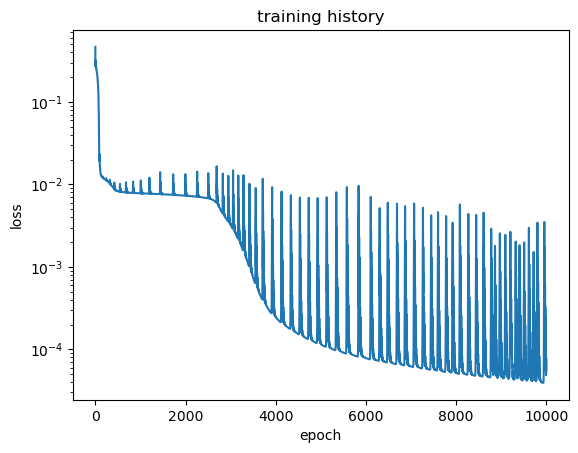

In [12]:
plt.semilogy(hist_train)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training history')
plt.show()
plt.close()

... and also the loss on the initial condition and boundary condition (training loss without the wave equation part)

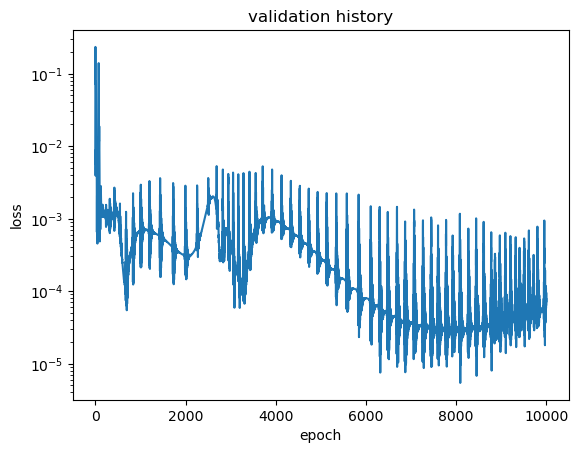

In [13]:
plt.semilogy(hist_val)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('validation history')
plt.show()
plt.close()

## Predict with PINN

We know that mathematically we can solve this wave equation to obtain a traveling wave solution
$$
u_{\rm forward}(t,x) = e^{-(x-at)^2}
$$
and propagates backwards after exceeding $x = x_{max}$
$$
u_{\rm backward}(t,x) = -e^{-[(x-x_{max}) + at]^2}
$$
In $[x_{min}, x_{max}]$, we get
$$
u_{\rm real}(t, x) = u_{\rm forward}(t,x) + u_{\rm backward}(t,x)
$$

In [14]:
func_u_forward = lambda t,x: tf.exp(-tf.square(x-a*t))
func_u_backward = lambda t,x: -tf.exp(-tf.square((x-2*x_max) + a*t))

def func_u_real(X):
    t, x = X[:, 0:1], X[:, 1:2]
    return func_u_forward(t, x) + func_u_backward(t, x)

Let's try to predict using the PINN trained before. Here we predict $u(t,x)$ at $x\in[x_{min}, x_{max}]$ and $t\in[t_{min}, t_{max}]$ with evenly sampled data.

In [15]:
N_pred = 200
N_view = 50

t_views = np.linspace(t_min, t_max + 5, N_view, dtype=DTYPE)
u_preds = []
u_reals = []
X_preds = []

for idx, t_view in enumerate(t_views):
    x_pred = tf.cast(tf.linspace([x_min], [x_max], N_pred), DTYPE)
    t_pred = tf.ones_like(x_pred, DTYPE) * t_view
    X_pred = tf.concat([t_pred, x_pred], axis=1)

    u_pred = model.predict(X_pred)
    u_real = func_u_real(X_pred)

    u_preds.append(u_pred)
    u_reals.append(u_real)
    X_preds.append(X_pred)

Estimate the prediction using L2 norm

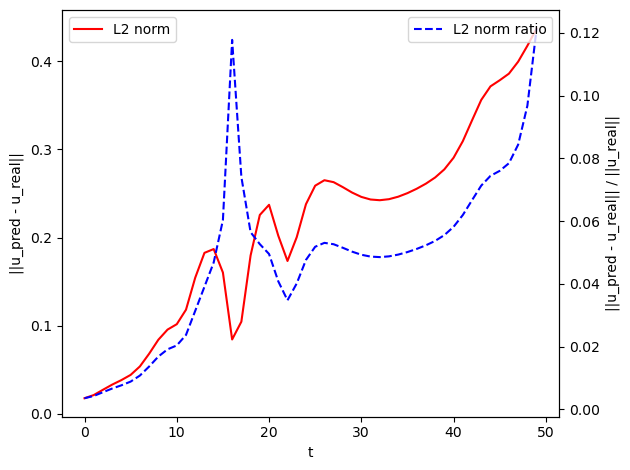

In [16]:
L2_norms = [tf.norm(u_pred - u_real, ord=2) for u_pred, u_real in zip(u_preds, u_reals)]
L2_norms_ratio = [l / tf.norm(u, ord=2) for l, u in zip(L2_norms, u_reals)]
plt.clf()
plt.plot(L2_norms, 'r-', label='L2 norm')
plt.xlabel('t')
plt.ylabel('||u_pred - u_real||')
plt.legend(loc='upper left')
plt.twinx()
plt.plot(L2_norms_ratio, 'b--', label='L2 norm ratio')
plt.ylabel('||u_pred - u_real|| / ||u_real||')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

Create an animation to show the prediction

In [17]:
def show_animation(t_views, X_preds, u_preds, u_reals):
    umax_pred = max([tf.reduce_max(u_pred) for u_pred in u_preds])
    umin_pred = min([tf.reduce_min(u_pred) for u_pred in u_preds])
    umax_real = max([tf.reduce_max(u_real) for u_real in u_reals])
    umin_real = min([tf.reduce_min(u_real) for u_real in u_reals])
    umax, umin = max(umax_pred, umax_real), min(umin_pred, umin_real)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_ylim([umin, umax])

    t0, x0 = t_views[0], X_preds[0][:, 1:2]
    u0_pred, u0_real = u_preds[0], u_reals[0]
    line1, = ax.plot(x0, u0_pred, 'r-', lw=2, label='prediction')
    line2, = ax.plot(x0, u0_real, 'b--', lw=2, alpha=0.6, label='real')
    fig.suptitle('t = %5.2f'%t0)

    ax.legend(loc='upper left')

    def animate(i):
        x = X_preds[i][:, 1:2]
        t = t_views[i]
        u_pred = u_preds[i]
        u_real = u_reals[i]
        line1.set_data(x, u_pred)
        line2.set_data(x, u_real)
        fig.suptitle('t = %5.2f'%t)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(t_views), interval=100)
    writer = animation.writers['ffmpeg']
    writer = writer(fps=10, metadata=dict(artist='AstroStudent'), bitrate=1800)
    anim.save('./my_animation.gif', writer=writer)
    plt.close()

show_animation(t_views, X_preds, u_preds, u_reals)

<img src="./my_animation.gif">
As shown in the figure, even using a simple 4-layer fully connected network, PINN is well able to learn the wave equations and the physical information from the initial and boundary conditions, and is able to predict their evolution accurately.

If we change the dimensionality of the input and provide appropriate conditions, by adjusting the loss function, PINN can learn 2-dimensional, 3-dimensional and even higher-dimensional information. This provides new ideas for solving the evolution of some complex physical scenarios, especially for those that lake of observational data but have clear physical model. From the perspective of machine learning, this network still has a lot of room for optimization through methods such as designing the intermediate layers rationally, or designing a dynamically adjusted weight for the loss function.

For me, it's quite fun😁

<img src="../example/2d-transmission_4x20_5000_0.0/figures/Predict_animated.gif">
<img src="../example/3d-transmission_3x20_5000_0.0/figures/Predict3D.gif">

## Notes, references and recommended readings



- Codes of the pictures above on my GitHub: [PINN-for-wave-equation](https://github.com/ChenfaZheng/PINN-for-wave-equation).
- An English article introducing PINN: Rasht‐Behesht, M., Huber, C., Shukla, K., & Karniadakis, G. E. (2022). Physics‐Informed Neural Networks (PINNs) for Wave Propagation and Full Waveform Inversions. Journal of Geophysical Research: Solid Earth, 127(5), e2021JB023120. ([arXiv version](https://arxiv.org/abs/2108.12035))
- A Chinese article introducing PINN: Tun, Z. H. A. O., Yu, Z. H. O. U., Yanqing, C. H. E. N. G., & Weiqi, Q. I. A. N. (2021). Solving forward and inverse problems of the heat conduction equation using physics-informed neural networks (基于内嵌物理机理神经网络的热传导方程的正问题及逆问题求解). 空气动力学学报, 39(5), 19-26.
- Special thanks to the discussion with Ruiqi Wang
- The code was done more than a half year ago, and there maybe some code that I've referenced from somewhere on the Internet but I cann't remember at all ... If so, please contact me and I will include the link here.
- I have little experience in this field (PINN) and I would welcome any guidance if there are any mistakes.

> The author reserves all rights to this article, for reproduction please contact zhengcf@mail.bnu.edu.cn

## Thanks for your reading!